In [3]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite
import math
import numpy as np
import streamlit as st

In [4]:
edges = []
nodes_in_network = set()
chosen_ego = 549089429

PATH = 'twitter/926981.edges'
with open(PATH, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            node1, node2 = parts
            edges.append((node1, node2))
            nodes_in_network.add(node1)
            nodes_in_network.add(node2)

# Create directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

G.add_node(chosen_ego)

# Connect ego to all other nodes (ego follows everyone)
for node in nodes_in_network:
    G.add_edge(chosen_ego, node)


degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)
closeness_cent = nx.closeness_centrality(G)

#quick stats
print(f"\nNetwork stats:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Density: {nx.density(G):.4f}")
print(f"Average Degree: {sum(dict(G.degree()).values()) / G.number_of_nodes()}")
print(f"Average In-Degree: {sum(dict(G.in_degree()).values()) / G.number_of_nodes()}")
print(f"Average Out-Degree: {sum(dict(G.out_degree()).values()) / G.number_of_nodes()}")
print(f"avg_degree_centrality: {sum(degree_cent.values()) / len(degree_cent)}")
print(f"max_degree_centrality: {max(degree_cent.values())}")
print(f"avg_betweenness: {sum(betweenness_cent.values()) / len(betweenness_cent)}")
print(f"max_betweenness: {max(betweenness_cent.values())}")
print(f"avg_closeness: {sum(closeness_cent.values()) / len(closeness_cent)}")
print(f"max_closeness: {max(closeness_cent.values())}")


Network stats:
Number of nodes: 203
Number of edges: 5822
Density: 0.1420
Average Degree: 57.35960591133005
Average In-Degree: 28.679802955665025
Average Out-Degree: 28.679802955665025
avg_degree_centrality: 0.2839584451055943
max_degree_centrality: 1.0742574257425743
avg_betweenness: 0.005638781656270178
max_betweenness: 0.08964284271353158
avg_closeness: 0.4316100003672475
max_closeness: 0.70271988288323


In [5]:
# File paths
edges_path = 'twitter/926981.edges'
feat_path = 'twitter/926981.feat'
featnames_path = 'twitter/926981.featnames'
egofeat_path = 'twitter/926981.egofeat'

chosen_ego = 549089429

In [6]:
feat = pd.read_csv(feat_path, sep=" ", header=None)
featnames = pd.read_csv(featnames_path, sep=" ", header=None)
egofeat = pd.read_csv(egofeat_path, sep=" ", header=None)

# For all nodes
feat.columns = ['node'] + featnames[1].tolist()

# For ego node (no node ID column)
egofeat.columns = featnames[1].tolist()

# Look at ego node's features (only show ones that are used)
ego_features = egofeat.iloc[0][egofeat.iloc[0] == 1]
print("Ego node features:")
print(ego_features)

Ego node features:
#MorrisseyonMars    1
@Coudal             1
@bailey             1
@biorhythmist       1
@czeins             1
@daveshumka         1
@edcasey            1
@fireland           1
@grahamclark        1
@hodgman            1
@hotdogsladies      1
@jessiechar:        1
@johnroderick       1
@kasper_hauser      1
@kwmurphy           1
@lianamaeby         1
@lonelysandwich     1
@matthewbaldwin     1
@mrgan              1
@paulandstorm       1
@robbaedeker        1
@shanecyr           1
@texburgher         1
@ylnt:              1
Name: 0, dtype: int64


In [7]:

print(feat['node'].dtype)         # likely int64
print(feat.columns[:20])          # check feature names and spacing


int64
Index(['node', '#'s', '#...', '#1', '#1:', '#2', '#2:', '#3', '#38', '#6',
       '#7', '#8', '#8!', '#990', '#Avengers', '#CES', '#CHQ02', '#FF',
       '#FiveYearEngagement', '#GameofThrones'],
      dtype='object')


In [8]:
# convert edges to ints (do this once after you build edges)
edges = [(int(u), int(v)) for u, v in edges]

# use a set for fast membership

for feature_name in feat.columns:
    if feature_name == 'node':      # skip the node id column
        continue
    nodes_with_feature = set(feat.loc[feat[feature_name] == 1, 'node'])
    internal_edges = [(u, v) for u, v in edges if u in nodes_with_feature and v in nodes_with_feature]
    print(f"Number of edges among nodes with {feature_name}: {len(internal_edges)}") # succesfully shows the amount of nodes with each feature.

Number of edges among nodes with #'s: 0
Number of edges among nodes with #...: 0
Number of edges among nodes with #1: 2
Number of edges among nodes with #1:: 1
Number of edges among nodes with #2: 0
Number of edges among nodes with #2:: 0
Number of edges among nodes with #3: 0
Number of edges among nodes with #38: 2
Number of edges among nodes with #6: 1
Number of edges among nodes with #7: 0
Number of edges among nodes with #8: 0
Number of edges among nodes with #8!: 0
Number of edges among nodes with #990: 2
Number of edges among nodes with #Avengers: 1
Number of edges among nodes with #CES: 0
Number of edges among nodes with #CHQ02: 2
Number of edges among nodes with #FF: 37
Number of edges among nodes with #FiveYearEngagement: 2
Number of edges among nodes with #GameofThrones: 0
Number of edges among nodes with #InternetMemeBands: 0
Number of edges among nodes with #JJGO: 6
Number of edges among nodes with #MaxFunCon: 9
Number of edges among nodes with #MaxFunCon.: 3
Number of edge

In [9]:
from collections import defaultdict
import json

# build mapping: feature -> set(nodes)
features_to_nodes = {}
for feat_name in feat.columns:
    if feat_name == 'node':
        continue
    nodes = set(feat.loc[feat[feat_name] == 1, 'node'])
    if nodes:                         # only keep non-empty sets
        features_to_nodes[feat_name] = nodes

# quick check
print("Number of features kept:", len(features_to_nodes))
for k in list(features_to_nodes)[:8]:
    print(k, len(features_to_nodes[k]))

# save to JSON (convert sets to lists)
with open('cache/feature_to_nodes.json', 'w', encoding='utf8') as f:
    json.dump({k: list(v) for k, v in features_to_nodes.items()}, f, ensure_ascii=False)

Number of features kept: 1000
#'s 2
#... 4
#1 11
#1: 2
#2 5
#2: 2
#3 4
#38 2


In [10]:
all_nodes = set(feat['node'].tolist())
B = nx.Graph()
user_nodes = list(all_nodes)
feature_nodes = list(features_to_nodes.keys())

# add nodes with bipartite attribute
B.add_nodes_from(user_nodes, bipartite=0, node_type='user')
B.add_nodes_from(feature_nodes, bipartite=1, node_type='feature')

# connect users to features
for feat_name, nodes in features_to_nodes.items():
    for u in nodes:
        B.add_edge(u, feat_name)

print("Bipartite graph: nodes", B.number_of_nodes(), "edges", B.number_of_edges())

# project to user-user graph with weights (# shared features)
G_proj = bipartite.weighted_projected_graph(B, user_nodes)

print("Projected user-user graph: nodes", G_proj.number_of_nodes(), "edges", G_proj.number_of_edges())
# show top edges by weight
top_proj = sorted(G_proj.edges(data=True), key=lambda x: x[2].get('weight',0), reverse=True)[:10]
print("Top projected edges (u,v,weight):", [(u,v,d['weight']) for u,v,d in top_proj])

Bipartite graph: nodes 1204 edges 3128
Projected user-user graph: nodes 204 edges 3750
Top projected edges (u,v,weight): [(32713532, 49508345, 29), (16594064, 6403332, 19), (816214, 610533, 15), (2317921, 14335262, 14), (5611152, 449336156, 13), (26868515, 14348594, 13), (761975, 1305941, 12), (789068, 3551171, 11), (15120464, 14335262, 11), (5611152, 18497302, 11)]


Subgraph: 125 nodes, 2554 edges


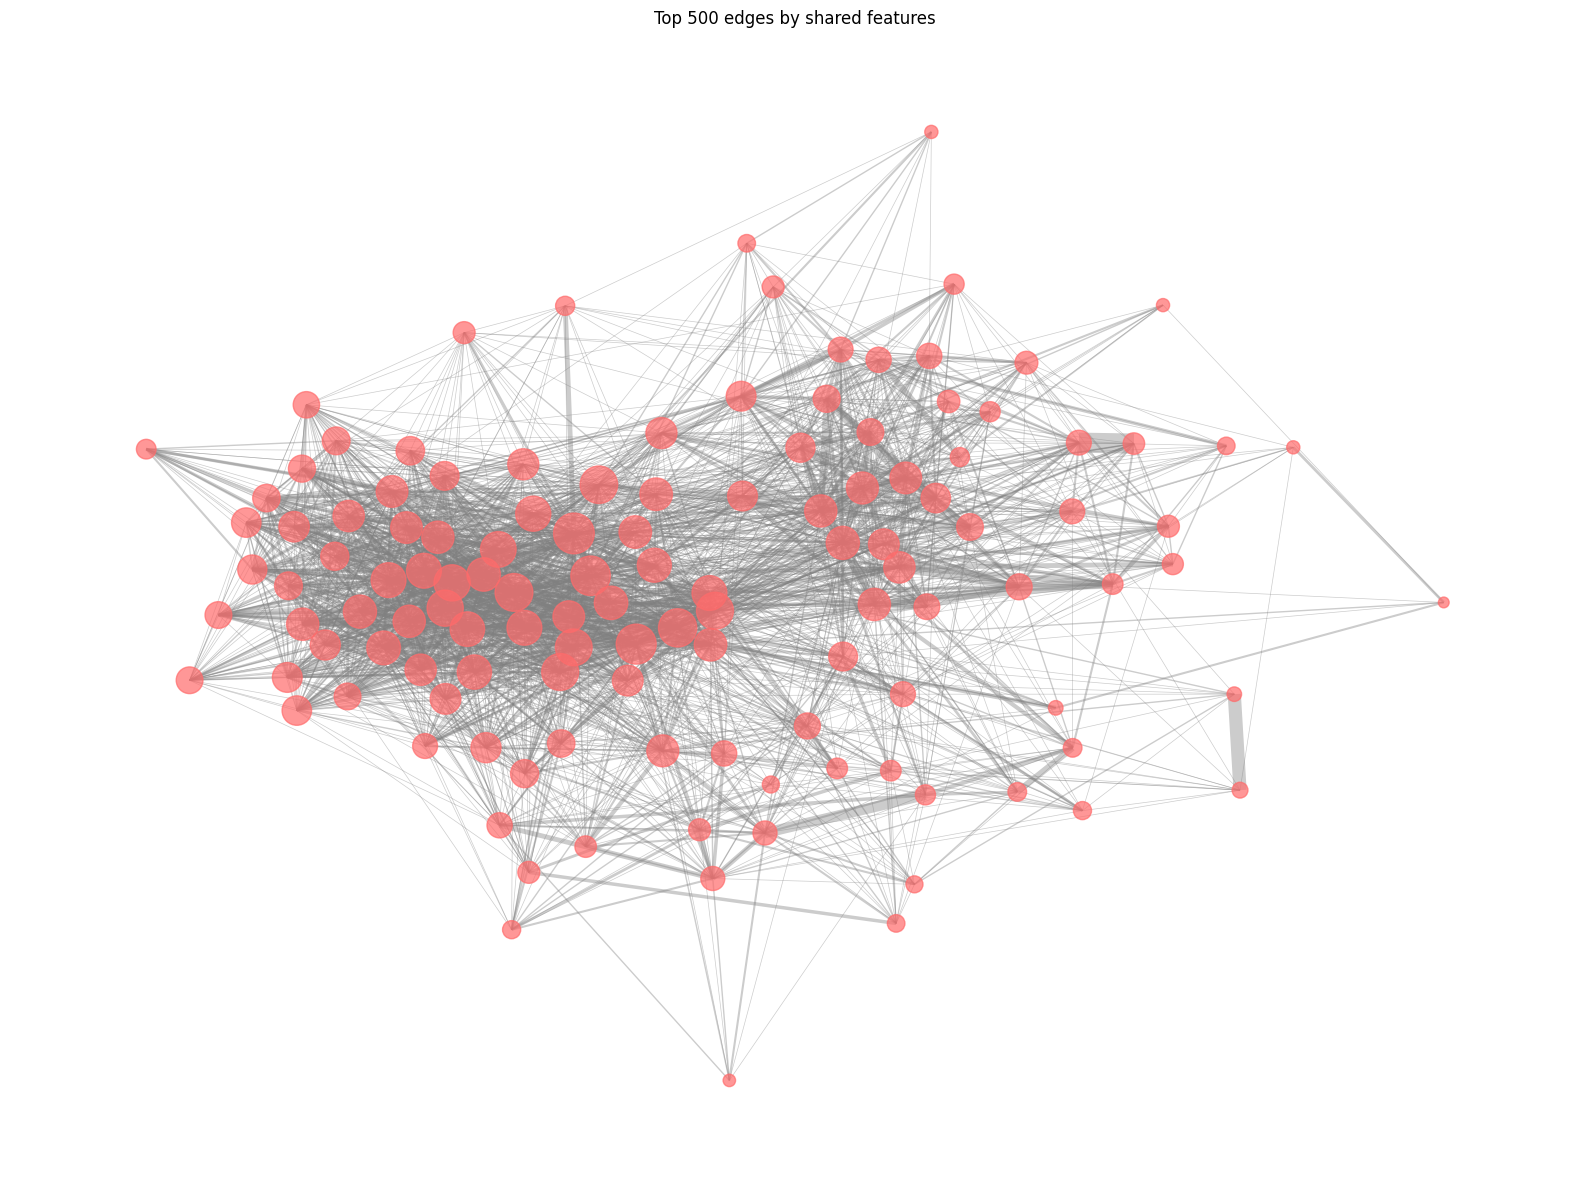

Saved to user_network_top.png


In [ ]:
# Get top 500 edges by weight
K = 2000
top_edges = sorted(G_proj.edges(data=True), key=lambda x: x[2].get('weight', 0), reverse=True)[:K]
nodes_in_top = set()
for u, v, d in top_edges:
    nodes_in_top.add(u)
    nodes_in_top.add(v)

G_top = G_proj.subgraph(nodes_in_top)

print(f"Subgraph: {G_top.number_of_nodes()} nodes, {G_top.number_of_edges()} edges")

plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G_top, k=1, iterations=100, seed=42)

# Node size by degree, edge width by weight
node_sizes = [G_top.degree(n) * 10 for n in G_top.nodes()]
edge_widths = [G_proj[u][v].get('weight', 1) / 2 for u, v in G_top.edges()]

nx.draw_networkx_nodes(G_top, pos, node_size=node_sizes, node_color='#FF6B6B', alpha=0.7)
nx.draw_networkx_edges(G_top, pos, width=edge_widths, alpha=0.4, edge_color='gray')
plt.title(f"Top {K} edges by shared features")
plt.axis('off')
plt.tight_layout()
plt.savefig('user_network_top.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved to user_network_top.png")

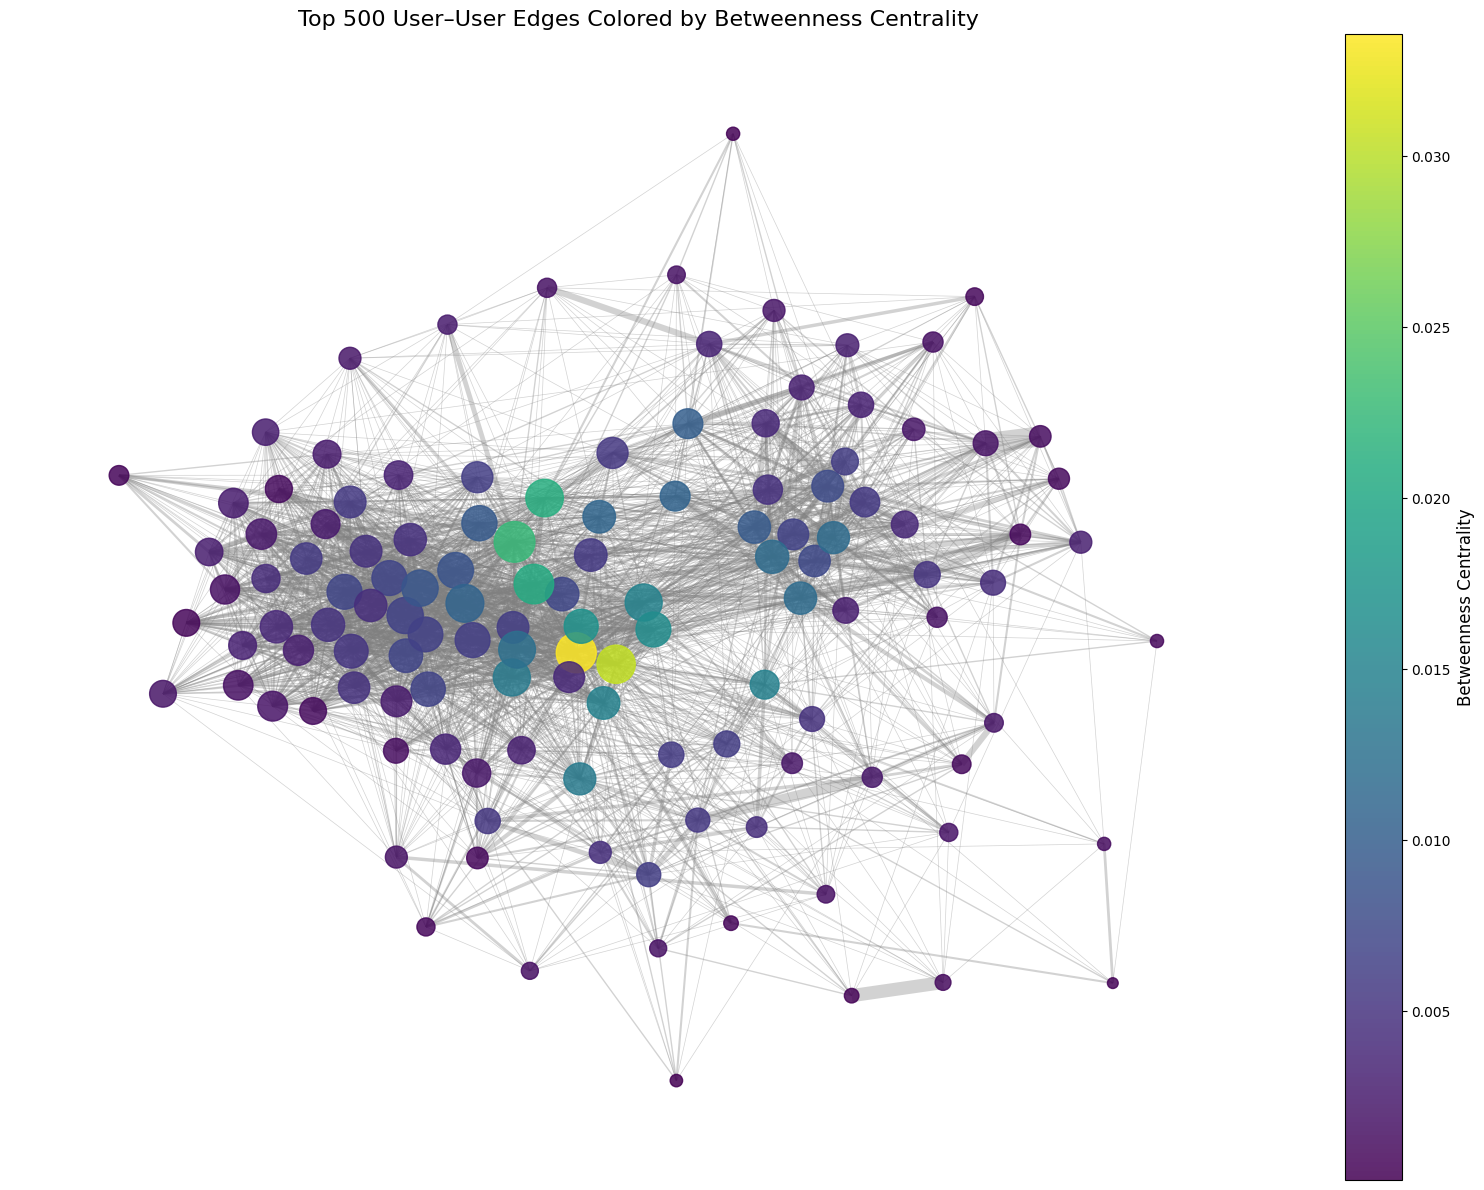

Saved to user_network_centrality.png


In [12]:
# Compute betweenness centrality =
bet = nx.betweenness_centrality(G_top, normalized=True)
# Normalize
node_colors = np.array([bet[n] for n in G_top.nodes()])
# Node size still based on degree
node_sizes = [G_top.degree(n) * 10 for n in G_top.nodes()]
# weighted spring so strong connections pull nodes closer
pos = nx.spring_layout(G_top, k=0.9, weight='weight', iterations=200, seed=42)

# Draw Nodes
plt.figure(figsize=(16, 12))

nodes = nx.draw_networkx_nodes(
    G_top, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap='viridis',
    alpha=0.85
)

# Draw Edges
nx.draw_networkx_edges(
    G_top, pos,
    width=edge_widths,
    alpha=0.35,
    edge_color='gray'
)
cbar = plt.colorbar(nodes)
cbar.set_label("Betweenness Centrality", fontsize=12)

plt.title(f"Top {K} User–User Edges Colored by Betweenness Centrality", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig('user_network_centrality.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved to user_network_centrality.png")

Top 10 nodes by betweenness centrality and their features:
Node 749863: BC=0.0896, Features=None
Node 2735631: BC=0.0515, Features=None
Node 14348594: BC=0.0449, Features=None
Node 838501: BC=0.0445, Features=None
Node 33423: BC=0.0371, Features=None
Node 3657081: BC=0.0332, Features=None
Node 935001: BC=0.0309, Features=None
Node 5984072: BC=0.0257, Features=None
Node 32423136: BC=0.0245, Features=None
Node 20: BC=0.0236, Features=None
